<h1 align="center"> Image Captioning (10 баллов) </h1>

В этом ноутбуке вы обучите сеть составлять подписи к изображениям.
![img](https://i.imgur.com/obITaMl.png)


#### План работы:

1. Использовать предобученную модель Inception v3 для преобразования изображений в векторы.

2. Добавить поверх неё LSTM.

3. Обучить модель на датасете [MSCOCO](http://cocodataset.org/#download).

### 1. Данные (0.5 балла)

In [1]:
%%time
# Read Dataset
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import json, os, random, math
from typing import List, Tuple, Dict
from collections import Counter, defaultdict


img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 627 ms, sys: 291 ms, total: 918 ms
Wall time: 1.26 s


In [2]:
SEED = 21
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)



Чтобы сэкономить ваше время, мы уже преобразовали все изображения из MSCOCO17 в векторы с помощью предобученной сети Inception_v3 из библиотеки [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

Весь процесс занимает от одного дня на CPU до примерно 10 минут на трёх GPU Tesla M40. [Если хотите попробовать сделать это самостоятельно — пожалуйста.](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).


In [3]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как видно, все подписи уже токенизированы и приведены к нижнему регистру. Теперь нам нужно разделить их и добавить специальные токены, обозначающие начало и конец подписи.

In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

print('\n'.join(' '.join(tokens) for tokens in captions[0]))


#START# people shopping in an open market for vegetables . #END#
#START# an open market full of people and piles of vegetables . #END#
#START# people are shopping at an open air produce market . #END#
#START# large piles of carrots and potatoes at a crowded outdoor market . #END#
#START# people shop for vegetables like carrots and potatoes at an open air market . #END#


Мы не хотим, чтобы сеть на каждом шаге предсказывала вероятности для миллиона слов, поэтому нужно немного сократить словарь.

Для этого посчитайте, **сколько раз встречается каждое слово** — так мы сможем решить, какие слова оставить в словаре.

In [5]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure

min_freq = 5

word_counts = Counter()
for img_i in range(len(captions)):
  for tokens in captions[img_i]:
    word_counts.update(tokens)



In [6]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

n_tokens = len(vocab)
print(f"Размер словаря: {n_tokens} (включая спецтокены)")

Размер словаря: 10403 (включая спецтокены)


In [7]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

Получим часть значений для дальнейшего использования

In [9]:
start_idx = word_to_index['#START#']
end_idx = word_to_index['#END#']
unk_idx = word_to_index['#UNK#']
pad_idx = word_to_index['#PAD#']

MAX_LEN = 20 # длина подписи для train
CODE_SIZE = int(img_codes.shape[1]) #размерность кода

print("CODE_SIZE =", CODE_SIZE)

CODE_SIZE = 2048


### 2. Построение нейронной сети (1.5 балла)

Как уже упоминалось, мы создадим RNN-модель для генерации текста, которая будет зависеть от векторов, полученных из CNN-части сети.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

Во время обучения мы будем использовать уже готовые вектора-признаков, а сеть Inception добавим на этапе инференса.


In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [11]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to
        # Начальное состояние LSTM
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=emb_size, padding_idx=pad_ix)

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM.
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=lstm_units, batch_first=True)

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units,n_tokens)

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        # начальное состояние LSTM из кода изображения
        initial_cell = self.cnn_to_c0(image_vectors) 
        initial_hid = self.cnn_to_h0(image_vectors)

        # compute embeddings for captions_ix
        # эмбеддиги входной последовательности
        captions_emb = self.emb(captions_ix)

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        h0 = initial_hid.unsqueeze(0) # [1, B, H]
        c0 = initial_cell.unsqueeze(0)# [1, B, H]
        lstm_out, _ = self.lstm(captions_emb, (h0, c0))

        # compute logits from lstm_out
        # логиты по словарю для каждого шага
        logits = (self.logits(lstm_out))

        return logits

In [12]:
network = CaptionNet(n_tokens)

In [13]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [14]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """

    # captions for input - all except last cuz we don't know next token for last one.
    # input – все кроме последнего
    # target – все кроме первого
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    # apply the network, get predictions for captions_ix_next
    # подаем последовательность сдвинутую на один шаг.
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    B,Tm1, V = logits_for_next.shape 


    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    loss = F.cross_entropy(
        logits_for_next.view(B* Tm1, V),
        captions_ix_next.view(B*Tm1),
        ignore_index=pad_ix
    )

    return loss.view(1)

In [15]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'


Добавьте ~~adam~~ ваш любимы оптимизатор для обучения.

In [16]:
opt = torch.optim.Adam(network.parameters(), lr=1e-3)

### 3. Обучение (5 баллов)

* Сначала реализуйте генератор батчей.
* Затем обучите сеть как обычно.

In [17]:
from sklearn.model_selection import train_test_split
captions = np.array(captions,dtype=object)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [18]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    #get images
    batch_images = img_codes[random_image_ix]

    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]

    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)


In [19]:
generate_batch(img_codes,captions,3)

(tensor([[0.7488, 0.5725, 0.1968,  ..., 0.0171, 0.1167, 0.1004],
         [0.1300, 0.0939, 0.3221,  ..., 0.6777, 0.3086, 0.2563],
         [0.0819, 0.7425, 0.4815,  ..., 0.4051, 1.5195, 0.0299]]),
 tensor([[   1,  360,   41,   24,  281,  474,   38,   35,   72,  247,    4,  918,
             2,    3,    3],
         [   1,   24,  279,   78,   24,   79,   58,   59,   79, 1197,  117,   73,
           382,   12,    2],
         [   1,  336,   41,   24,   97,  357,   15,   24, 2317,    6,   24,  394,
            12,    2,    3]]))

Обучайте модель на мини-батчах, как обычно. Периодически проверяйте качество на валидационном наборе.

#### **Советы**

* Если тренировочный лосс почти равен нулю или модель генерирует бессмысленный текст — проверьте, что вы предсказываете следующее слово, а не текущее или слово через два шага.

* Если модель создаёт плавные, но нерелевантные описания:

  * возможно, рекуррентная сеть не получает векторы изображения;

  * также это может быть следствием взрыва градиентов — попробуйте клиппинг или перезапуск обучения;

  * наконец, возможно, модель просто нужно обучить дольше.

* Кросс-энтропия — слабый показатель переобучения:

  * модель может переобучиться по валидационной кросс-энтропии, но при этом продолжать улучшать качество генерации;

  * используйте ручную оценку или автоматические метрики, такие как CIDEr или BLEU.

* Рекомендуется периодически проверять сеть с помощью блока “apply trained model” — можно остановить обучение, протестировать несколько примеров и продолжить.

* Типичные значения функции потерь: около 3–5, если усреднять по времени,
или масштабировать по длине при суммировании. Разумные подписи начинают появляться при лоссе 2.8–3.0.

In [20]:
batch_size = 256  # adjust me
n_epochs = 50  # adjust me
n_batches_per_epoch = 250  # adjust me
n_validation_batches = 20  # how many batches are used for validation after each epoch

In [21]:
from tqdm import tqdm

for epoch in range(n_epochs):

    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):

        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))


        # clear old gradients; do a backward pass to get new gradients; then train with opt
        opt.zero_grad()
        loss_t.backward()
        torch.nn.utils.clip_grad_norm_(network.parameters(), 5.0)
        opt.step()

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch

    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 250/250 [01:44<00:00,  2.39it/s]



Epoch: 0, train loss: 4.528032634735108, val loss: 3.7952324986457824


100%|██████████| 250/250 [01:41<00:00,  2.45it/s]



Epoch: 1, train loss: 3.4920492753982546, val loss: 3.2713743686676025


100%|██████████| 250/250 [01:41<00:00,  2.45it/s]



Epoch: 2, train loss: 3.1523079986572267, val loss: 3.0600473642349244


100%|██████████| 250/250 [01:45<00:00,  2.38it/s]



Epoch: 3, train loss: 2.9686330099105835, val loss: 2.935402524471283


100%|██████████| 250/250 [01:42<00:00,  2.45it/s]



Epoch: 4, train loss: 2.861503545761108, val loss: 2.8505321860313417


100%|██████████| 250/250 [01:51<00:00,  2.25it/s]



Epoch: 5, train loss: 2.78356831741333, val loss: 2.8017904281616213


100%|██████████| 250/250 [01:45<00:00,  2.37it/s]



Epoch: 6, train loss: 2.721539179801941, val loss: 2.7219003319740294


100%|██████████| 250/250 [01:48<00:00,  2.30it/s]



Epoch: 7, train loss: 2.673308135032654, val loss: 2.6820672512054444


100%|██████████| 250/250 [01:48<00:00,  2.30it/s]



Epoch: 8, train loss: 2.6416908168792723, val loss: 2.6327123165130617


100%|██████████| 250/250 [01:45<00:00,  2.36it/s]



Epoch: 9, train loss: 2.604428699493408, val loss: 2.623220181465149


100%|██████████| 250/250 [01:56<00:00,  2.15it/s]



Epoch: 10, train loss: 2.5756440677642822, val loss: 2.590481388568878


100%|██████████| 250/250 [01:49<00:00,  2.29it/s]



Epoch: 11, train loss: 2.5483445358276366, val loss: 2.611116147041321


100%|██████████| 250/250 [01:50<00:00,  2.27it/s]



Epoch: 12, train loss: 2.529916504859924, val loss: 2.584058141708374


100%|██████████| 250/250 [01:45<00:00,  2.36it/s]



Epoch: 13, train loss: 2.5071716899871825, val loss: 2.5578199863433837


100%|██████████| 250/250 [01:44<00:00,  2.39it/s]



Epoch: 14, train loss: 2.4867790126800537, val loss: 2.548239505290985


100%|██████████| 250/250 [01:44<00:00,  2.39it/s]



Epoch: 15, train loss: 2.4644434156417847, val loss: 2.545162570476532


100%|██████████| 250/250 [01:42<00:00,  2.44it/s]



Epoch: 16, train loss: 2.4546485795974733, val loss: 2.5096962571144106


100%|██████████| 250/250 [01:43<00:00,  2.41it/s]



Epoch: 17, train loss: 2.434760872840881, val loss: 2.489831066131592


100%|██████████| 250/250 [01:42<00:00,  2.44it/s]



Epoch: 18, train loss: 2.4252293252944948, val loss: 2.5192824006080627


100%|██████████| 250/250 [01:41<00:00,  2.46it/s]



Epoch: 19, train loss: 2.411247874259949, val loss: 2.4914587140083313


100%|██████████| 250/250 [01:42<00:00,  2.43it/s]



Epoch: 20, train loss: 2.3928833627700805, val loss: 2.4931846976280214


100%|██████████| 250/250 [01:42<00:00,  2.44it/s]



Epoch: 21, train loss: 2.3827856578826903, val loss: 2.501774263381958


100%|██████████| 250/250 [01:45<00:00,  2.37it/s]



Epoch: 22, train loss: 2.3792120180130003, val loss: 2.466843831539154


100%|██████████| 250/250 [01:43<00:00,  2.41it/s]



Epoch: 23, train loss: 2.3691008100509645, val loss: 2.4465604782104493


100%|██████████| 250/250 [01:45<00:00,  2.37it/s]



Epoch: 24, train loss: 2.356618947982788, val loss: 2.4723823189735414


100%|██████████| 250/250 [01:45<00:00,  2.37it/s]



Epoch: 25, train loss: 2.3506807193756103, val loss: 2.4676511883735657


100%|██████████| 250/250 [01:43<00:00,  2.43it/s]



Epoch: 26, train loss: 2.3392362899780275, val loss: 2.4590113759040833


100%|██████████| 250/250 [01:44<00:00,  2.39it/s]



Epoch: 27, train loss: 2.326073931694031, val loss: 2.459617590904236


100%|██████████| 250/250 [01:43<00:00,  2.43it/s]



Epoch: 28, train loss: 2.322779635429382, val loss: 2.4366172790527343


100%|██████████| 250/250 [01:40<00:00,  2.48it/s]



Epoch: 29, train loss: 2.311167820930481, val loss: 2.4091963529586793


100%|██████████| 250/250 [01:46<00:00,  2.35it/s]



Epoch: 30, train loss: 2.3097636013031004, val loss: 2.4586493015289306


100%|██████████| 250/250 [01:45<00:00,  2.37it/s]



Epoch: 31, train loss: 2.297985753059387, val loss: 2.4527087450027465


100%|██████████| 250/250 [01:43<00:00,  2.41it/s]



Epoch: 32, train loss: 2.294732355117798, val loss: 2.4270745873451234


100%|██████████| 250/250 [01:44<00:00,  2.39it/s]



Epoch: 33, train loss: 2.287109052658081, val loss: 2.4175962686538695


100%|██████████| 250/250 [01:43<00:00,  2.43it/s]



Epoch: 34, train loss: 2.2858888301849367, val loss: 2.410896158218384


100%|██████████| 250/250 [01:43<00:00,  2.42it/s]



Epoch: 35, train loss: 2.272310468673706, val loss: 2.4253595232963563


100%|██████████| 250/250 [01:44<00:00,  2.38it/s]



Epoch: 36, train loss: 2.279602921485901, val loss: 2.422209620475769


100%|██████████| 250/250 [01:45<00:00,  2.36it/s]



Epoch: 37, train loss: 2.2643263568878176, val loss: 2.455437934398651


100%|██████████| 250/250 [01:44<00:00,  2.39it/s]



Epoch: 38, train loss: 2.2578780088424684, val loss: 2.4158315420150758


100%|██████████| 250/250 [01:48<00:00,  2.30it/s]



Epoch: 39, train loss: 2.255973335266113, val loss: 2.392137610912323


100%|██████████| 250/250 [01:45<00:00,  2.36it/s]



Epoch: 40, train loss: 2.2564055461883545, val loss: 2.402409613132477


100%|██████████| 250/250 [01:42<00:00,  2.43it/s]



Epoch: 41, train loss: 2.2435404109954833, val loss: 2.411989140510559


100%|██████████| 250/250 [01:46<00:00,  2.35it/s]



Epoch: 42, train loss: 2.238399886131287, val loss: 2.4161424040794373


100%|██████████| 250/250 [01:41<00:00,  2.46it/s]



Epoch: 43, train loss: 2.2338715562820433, val loss: 2.380616247653961


100%|██████████| 250/250 [01:44<00:00,  2.39it/s]



Epoch: 44, train loss: 2.2275286321640015, val loss: 2.3789574265480042


100%|██████████| 250/250 [01:41<00:00,  2.47it/s]



Epoch: 45, train loss: 2.2243260679244994, val loss: 2.3939544200897216


100%|██████████| 250/250 [01:46<00:00,  2.34it/s]



Epoch: 46, train loss: 2.223684379577637, val loss: 2.39574590921402


100%|██████████| 250/250 [01:42<00:00,  2.43it/s]



Epoch: 47, train loss: 2.2162421760559083, val loss: 2.3766942024230957


100%|██████████| 250/250 [01:44<00:00,  2.39it/s]



Epoch: 48, train loss: 2.2203366346359252, val loss: 2.394567334651947


100%|██████████| 250/250 [01:56<00:00,  2.15it/s]



Epoch: 49, train loss: 2.2180669059753417, val loss: 2.3872759103775025
Finished!


### 4. Применяем обученную модель (0.5 балла)

Теперь загрузим предобученнную Inceprion модель и посмотрим, на что способна наша модель.


In [22]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


#### **Генерируем подписи**

Функция ниже генерирует подписи, выбирая слова на основе вероятностей, предсказанных моделью.

Реализация здесь простая, но неэффективная (её сложность квадратична по числу шагов LSTM).

In [23]:
def generate_caption(image, caption_prefix=("#START#",),
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

(np.float64(-0.5), np.float64(298.5), np.float64(298.5), np.float64(-0.5))

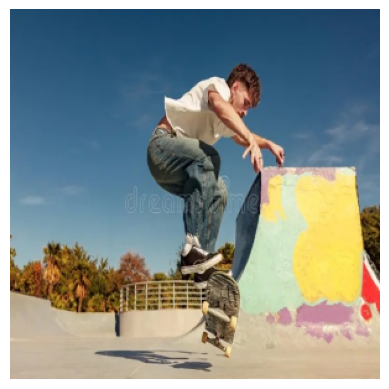

In [24]:
from matplotlib import pyplot as plt
from skimage.transform import resize
import numpy as np
%matplotlib inline

!mkdir -p data

img = plt.imread('data/img.jpg')
img = resize(img, (299, 299), anti_aliasing=True, preserve_range=True)
img = img.astype(np.float32) / 255.0

plt.imshow(img)
plt.axis('off')

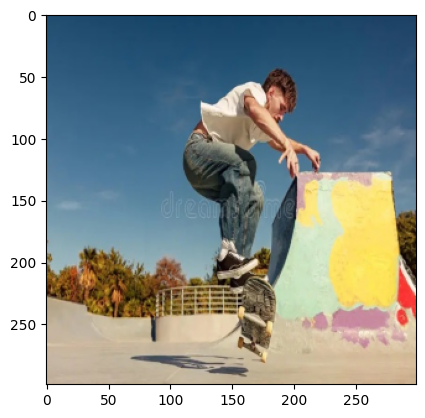

In [25]:
plt.imshow(img)

In [26]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a ramp .
a young man riding a skateboard on top of a ramp .
a man riding a skateboard on top of a cement ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on top of a ramp .
a man riding a skateboard down a ramp .
a skateboarder is doing a trick on a ramp .


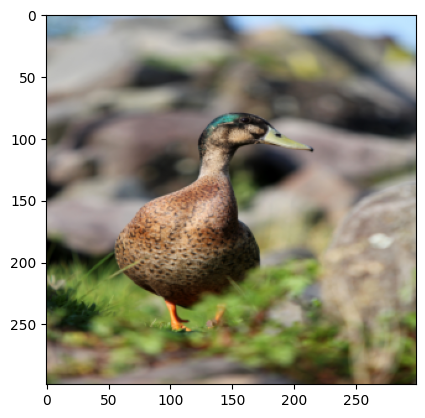

a bird is standing on a branch with a bird on it .
a bird is flying over a body of water
a bird is standing on a rock in the water .
a bird is standing on a rock in the water .
a bird is flying over a body of water .
a bird is flying over a rock in the woods .
a bird is standing on a branch in the water .
a bird is flying over a body of water .
a bird is flying over a body of water .
a bird is standing on a branch in the water .


In [27]:
img = plt.imread('data/img1.jpg')
img = resize(img, (299, 299), anti_aliasing=True, preserve_range=True)
img = img.astype(np.float32) / 255.0

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

### 5. Demo (2.5 балла)
##### **Найдите как минимум 10 изображений для теста.**

* Серьёзно, это часть задания — подготовьте хотя бы 10 картинок для генерации подписей.

* Сначала проверьте работу модели на простых изображениях, прежде чем переходить к более сложным.

* В вашем наборе должны быть примеры как удачных, так и неудачных подписей — проявите креативность :)

* Используйте фотографии, а не анимацию, 3D или рисунки — иначе придётся переобучать CNN на аниме.

* Обратите внимание на соотношение сторон изображений.

- Простые изображения (один предмет крупным планом на простом фоне): img_01, img_02;
- Средние (сцены с несколькими объектами): img_03, img_04, img_05;
- Сложные (сцены с множеством деталей, в динамике): img_06, img_07, img_08;
– Краевые случаи:
  - низкая освещённость: img_09;
  - частично перекрытые объекты: img_10;
  - маленький объект в дали: img_11;
  - необычный ракурс: img_12;


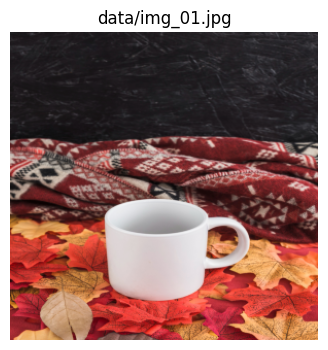

=== data/img_01.jpg ===
a close up of a plate of food on a table
a brown coffee cup sitting on a white plate on a table .
a brown table holding a piece of cloth and two cups of coffee .
a close up of a plate of food with a red umbrella
a coffee cup on a table with a drink and a basket of coffee .
a cup of coffee , a cup of coffee , and a half eaten donut on a white plate .
a white plate topped with a white plate of bread .
a cup of coffee is sitting on a table
a #UNK# and a cup of coffee on a white table .
a brown coffee cup sitting on top of a wooden table .
a cup of coffee on a white plate .
a close up of a person holding a cup of coffee
a plate of food on a table with a fork .



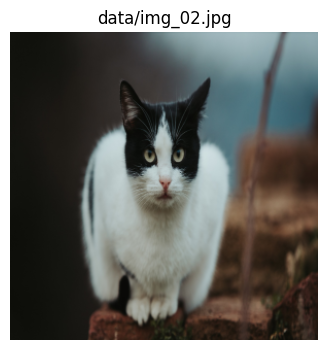

=== data/img_02.jpg ===
a cat laying in front of a black cat .
a cat is sitting on top of a wooden chair .
a cat sitting next to a half pipe looking in the window .
a cat is looking out of a window .
a cat that is sitting on a window sill .
a cat is looking out of a window
a cat sits on a bathroom sink under a window .
a cat is sitting on a chair outside .
a cat sits on the edge of a chair .
a cat is looking at itself in a window .
a cat is looking at the camera in a bowl .
brown and white cat sitting on top of a bowl with a bottle in it .
a cat is sitting on a toilet next to a curtain .



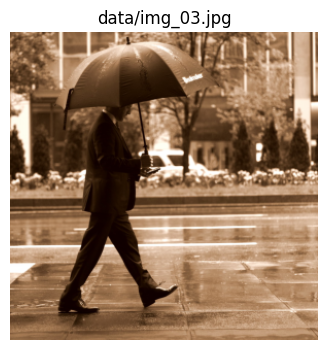

=== data/img_03.jpg ===
a woman in a wet suit carrying an umbrella .
a young girl holding an umbrella and walking down a street .
a woman holding an umbrella and talking on a cellphone .
a woman in a raincoat and an umbrella is walking
a woman holding an umbrella and a man standing in the rain
a man with a pink and black umbrella on a rainy day .
a man is holding an umbrella walking a brick building .
a young woman holding an umbrella and holding a sign .
a woman with a umbrella is walking on the street .
a woman walking down a street holding a yellow umbrella .
a woman holds an umbrella in a line .
a young woman in a raincoat , holding a black umbrella .
a woman with a hat is walking on a sidewalk .



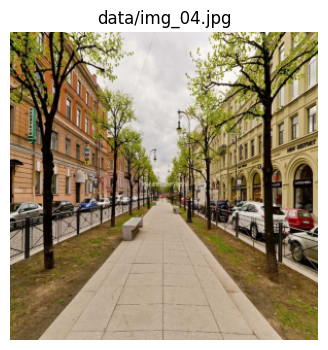

=== data/img_04.jpg ===
a park with benches and trees in the background .
a very dimly lit set of a city street .
a red and white motorcycle parked on the side of the road .
a bike parked on a path in a forested area .
a car parked on the side of the road .
a bike parked next to a brick wall .
a small and black bench lined up against a brick building .
a very big pretty blue park in the middle of a forest
a set of a street corner with two street lamps on it .
a white bus parked on the side of a road .
a couple of park benches with a small shack inside .
a lone bench sits on the side of a road .
a green and white image of a train station with a train parked on the tracks .



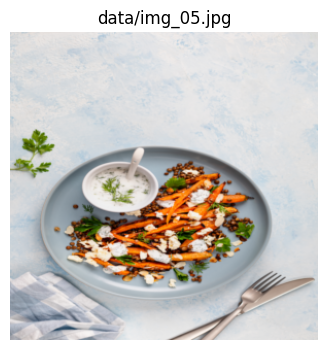

=== data/img_05.jpg ===
a table with bowls of food and a bowl of soup on it .
a plate full of food and a fork .
a plate of food with a pizza on it .
a table that has a vase of flowers , a bottle and a glass of water .
a plate of food that includes sausage and a fork on a table .
a plate with a cake on top and a fork .
a plate of food on the table at a restaurant
a plate of food with a fork on the table
a plate of food that is on a table .
a plate that has a slice of pizza on it .
a plate of cake on a table with a fork and knife .
a table with a plate of food and a fork
a plate with a bowl of cereal and a bowl of meat



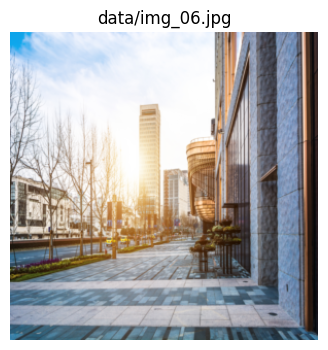

=== data/img_06.jpg ===
a street scene with a white roof and a street sign .
a street light on an orange pole in the corner of a street .
a street pole with a fire hydrant on the sidewalk
a red and white fire hydrant sitting on the side of the street .
a street sign and a lamppost in a city .
a street corner with a stop light and a red light
a street scene with a stop sign and a lamp post .
a parking meter on a city street next to a tree .
a silver pole with a street sign and a street light
a red fire hydrant on a city street .
a view of a small building in the street .
a empty street on a corner near a building .
the fire hydrant is painted red and white .



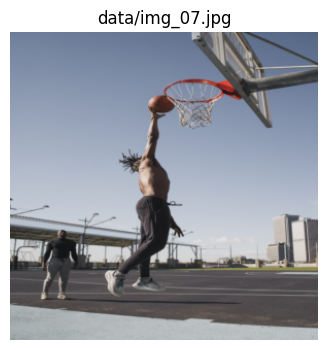

=== data/img_07.jpg ===
a man is standing on the court holding a tennis racket .
a woman standing in a field with a tennis racquet .
a couple of people flying kites in a park .
a man is trying to catch a tennis ball .
a man jumping in the air with a frisbee .
a woman jumps to hit a tennis ball
a man holding a tennis racquet in front of a crowd .
a couple of people standing on top of a tennis court .
a man playing frisbee on a high pressure .
a man is playing tennis on a tennis court .
a man taking a swing at a tennis ball
a tennis player jumps to hit a tennis ball .
a man jumping up to reach a tennis ball



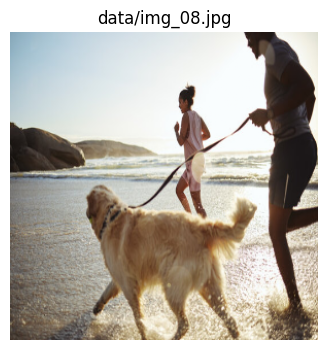

=== data/img_08.jpg ===
a dog and their dog on a leash and a frisbee in the background .
a dog and a dog are in the snow
a dog is walking through the snow with a dog on their feet .
a couple of people that are on a couch .
a man and a dog are on a black horse .
a man and dog on a bed with a dog
a dog and an umbrella are on the beach .
a dog and a dog on a leash in a park .
a dog and a dog on a leash in the snow
a dog that is standing on top of a surfboard .
a dog is standing on a boat with a dog .
a person with a dog and a dog on a leash .
a dog is playing frisbee on a sandy beach .



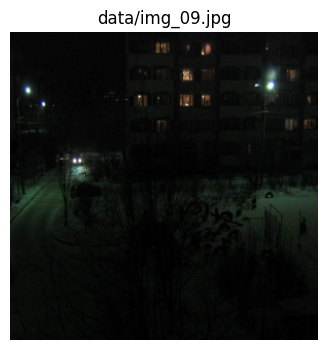

=== data/img_09.jpg ===
a small bird is on a white board on a white block .
a black bird is hanging in a mirror .
a white bird is on a white surface .
an elephant is eating food from the ground .
a small bird is sitting on a white rope .
a bird is glowing in a small cage .
a red and white fire hydrant on a city street
the black water is rolled in to a lake .
a bird bath in a pot on a glass .
a water skier is resting on the edge of a bowl .
a water fountain with a bird flying over it .
a brown and white vase holding a green plant
a water fountain in the sea by a young man flying through the sky .



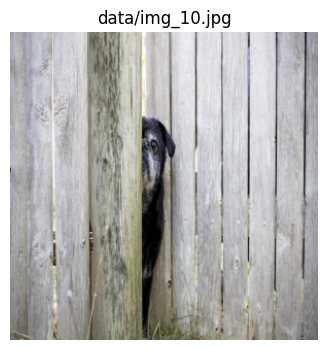

=== data/img_10.jpg ===
a black and white cat laying on a wooden bench .
a pair of brown teddy bears sitting in a room .
two black and white birds sitting on top of a wooden floor .
a black and white cat sitting on top of a metal railing .
a black and white cat sitting on top of a tree
the black and white is standing on a rock
a black and black cat is standing next to a wood fence .
black and white picture of an animal sitting on the grass .
a very black and white dog sitting on top of a wooden floor .
the black and white cat is sitting next to the small tree .
a cat sitting on a patch of grass near a fence .
a black and white cat looking at the camera .
a large black and white cat sitting near a wooden fence .



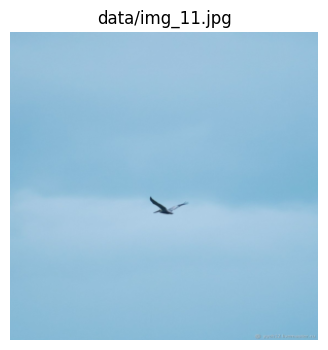

=== data/img_11.jpg ===
a plane is flying in the air over a mountain
a blue and grey bird flying over a blue top .
a jet in the air with the wings of the wing
a large bird is flying high in the air .
a bird on a perch in the water .
a picture of a #UNK# on a green field .
a small bird on top of a white capped field .
a seagull flies high above the ocean .
a close up of a small air plane flying in the air
a bird is flying over a wave on the ground .
a small propeller plane on a beach with some sun streaming around
a single bird in flight on a cloudy day .
a small plane is flying high in the sky .



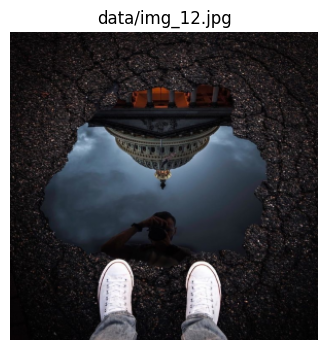

=== data/img_12.jpg ===
a person is standing on some old chairs
a person on a skate board in the air
a man holding a kite in a field
a person holding a skateboard and a ball on the ground .
a person in a red top suit sitting on a skateboard .
a clock with people sitting on it .
a person holding a battered umbrella on top of a wooden structure .
a person in a red shirt is jumping a skateboard in a #UNK#
a person taking a picture of a fighter jet on a bench .
a person holding a snowboard in a good sky
a table that has a bunch of bananas on it .
a person in a suit and tie seen riding on a skateboard .
a couple of birds sitting on top of a wooden plank .



In [28]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

def demo_images(n_samples=10, temperature=1.5, show=True):
    for idx in range(1, n_samples):
        path = f"data/img_{idx:02d}.jpg"
        try:
            img = plt.imread(path)
        except FileNotFoundError:
            print(f"Не найден файл: {path}")
            continue

        img_resized = resize(img, (299, 299), anti_aliasing=True, preserve_range=True)
        img_resized = img_resized.astype(np.float32) / 255.0

        if show:
            plt.figure(figsize=(4, 4))
            plt.imshow(img_resized)
            plt.title(path)
            plt.axis('off')
            plt.show()

        print(f"=== {path} ===")
        for i in range(n_samples):
            tokens = generate_caption(img_resized, t=temperature)
            print(' '.join(tokens[1:-1]))
        print()

demo_images(n_samples=13, temperature=1.5, show=True)

### Выводы по результатам
Рассмотрим выборочно некоторые изображения, сформулированные заключения также применимы и на другие примеры.

- img_01: предмет определён верно, модель галлюцинирует «coffee» — внутри чашки ничего не видно, но в датасете почти все «cup» → «cup of coffee», контекст (осенние листья, плед) вообще не учитывается — модель берёт самый частотный паттерн, иногда дублирует фразы: «a cup of coffee and a cup of coffee».

Вывод: объект распознаёт, но описывает не изображение, а среднее по датасету: «если есть cup -> скорее всего coffee -> стоит на table».

- img_02: пол перепутан в основном перепутан, место угадала по контексту: «in a city» — разумно для улицы с домами,зонт определён верно и стабильно — это главный объект на фото.

Вывод: модель хорошо работает по главному крупному объекту (umbrella), но слабее по: атрибутам людей (пол), типу действия (walking vs standing), количеству людей (иногда «next to a woman» — придумывает второго человека).

- img_04: это уличная сцена, а не поезд, модель может съезжать в домен trains / tracks / bridge. Почему так случилось?
	- линия визуально в фичах может быть похожа на «рельсы»;
	- объект в кадре не выделен крупно, картинка «менее уверенная», модель уходит в самый частотный шаблон.

Вывод: на «широких» сценах без чётко доминирующего объекта модель может сильно галлюцинировать и вообще подменять класс сцены. В целом результат хороший, большая часть описаний ложится на картинку.

- img_08: стабильно видит dog, часто угадывает beach / water, придумывает frisbee, иногда пишет “a dog and a dog” (ошибка count), странные связи “standing on a leash”, повторы.

Вывод: сильный языковой приоритет (dog→frisbee/play), + встречное солнце/движение, признаки «смазаны», главный объект не один.

- img_09: полный разброс — surfboard/kite/bird/fire hydrant.

Вывод: очень низкая освещённость, мало текстуры, следовательно слабый CNN-вектор, декодер уходит в разные шаблоны.

- img_10: почти везде пишет “black and white cat … on a wooden fence”, неверно на фото собака, но «забор» угадан.

Вывод: видна часть морды животного (усложняет идентификацию + порода мопс, тяжеловато), также сильный паттерн cat + fence, сдвиг к типичному сюжету.

- img_12: человека распознали, остальное мимо kite/skateboard/umbrella/snowboard.

Вывод: необычная геометрия, ракурс, мало «типичных» опорных признаков, следовательно декодер падает в языковые шаблоны


Таким образом:

1.	Сильные стороны
- Когда в кадре один крупный объект и простой контекст (кружка, зонт, собака крупно), подписи разумные.

2. Слабые места
- Языковой приоритеты сильно доминируют: модель «додумывает» сцены.
- Плохие условия (ночь, динамика) и необычная геометрия (отражение) ломают визуальные признаки, что приводит к галлюцинациям.
- Мелкие объекты – промах по классу и действию.
– Повторы при высокой temperuture.


![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)

> Примечание: Это задание адаптировано по материалам курса "Deep Learning" (Skoltech).
